# Machine Learning Model for Titanic dataset
This notebook has been set up do perform some straight forward Machines Learning against the famous titanic dataset, with the classification target of if the passengers had survived or not. 

This is to prepare a model to save down ready to then be used to predict new data and provide the result vis the FastAPI web application. 

## Import Relevant Libraries

In [242]:
import xgboost as xgb                                           # Machine Learning model to use 
from xgboost import plot_importance

import shap
import pandas as pd                                             # Data Analysis and dataframes
import sklearn  as sk   # Used in general Machine Learning
import matplotlib.pyplot as plt                                 # Data Visualisation
import seaborn as sns                                           # Data Visualisation 

import dtreeviz                                                 # decision tree visualisation
from sklearn.model_selection    import train_test_split         # split datasets ready for modelling
from sklearn import tree                                        # Desicion trees modelling
from sklearn import linear_model as lm                          # for linear models

import pickle


pd.options.display.float_format = '{:.2f}'.format

## Load in dataset

In [190]:
# Load in Dataset
#############raw = pd.read_csv("D:/Coding/git_projects/ML/Datasets/titanic.csv")
raw = pd.read_parquet('tit.parquet')

display(raw.head())

,Survived,Pclass,Age,Fare,Cabin,Gender,Family_size,Emb_Southampton,Emb_Cherbourg,Emb_Queenstown
0,0,3,22.00,7.25,0,True,2,True,False,False
1,1,1,38.00,71.28,1,False,2,False,True,False
2,1,3,26.00,7.92,0,False,1,True,False,False
3,1,1,35.00,53.10,1,False,2,True,False,False
4,0,3,35.00,8.05,0,True,1,True,False,False


## Split into train and test datasets


In [191]:
#copy of raw into data
data = raw.copy()

# Set target for machine learning task
#--------------------------------------
y_target = data['Survived']

# Make X by removing y_target
#--------------------------------------
if y_target.name in data.columns:
    X = data.drop(columns=[y_target.name])

# split data into train and test
#--------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size = 0.3, random_state = 27)

display(X_train)


,Pclass,Age,Fare,Cabin,Gender,Family_size,Emb_Southampton,Emb_Cherbourg,Emb_Queenstown
13,3,39.00,31.27,0,True,7,True,False,False
362,3,45.00,14.45,0,False,2,False,True,False
761,3,41.00,7.12,0,True,1,True,False,False
197,3,42.00,8.40,0,True,2,True,False,False
454,3,30.00,8.05,0,True,1,True,False,False
...,...,...,...,...,...,...,...,...,...
824,3,2.00,39.69,0,True,6,True,False,False
543,2,32.00,26.00,0,True,2,True,False,False
840,3,20.00,7.92,0,True,1,True,False,False
696,3,44.00,8.05,0,True,1,True,False,False


## Show information regarding data to use for training

In [192]:
# Top 20 ages with most occurances
X_train.Age.value_counts()[:20].rename_axis('unique_values').reset_index(name = 'counts').style.background_gradient()

C:\Users\lothe\AppData\Local\Temp\ipykernel_15864\2811193591.py:2: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead


,unique_values,counts
0,30.000000,143
1,24.000000,21
2,22.000000,20
3,19.000000,20
4,18.000000,19
5,36.000000,16
6,28.000000,16
7,21.000000,16
8,29.000000,15
9,32.000000,15


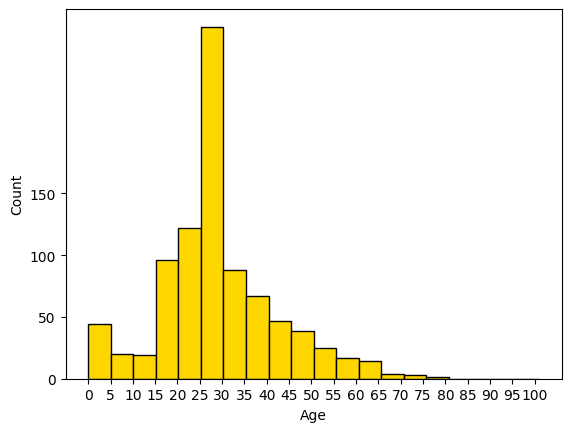

In [193]:
# Plot histogram with matplotlib pyplot

ax = sns.histplot(data['Age'],binrange=(0,101), binwidth= 5, color='gold', alpha = 1)
ax.set_xticks(range(0,101,5))
ax.set_yticks(range(0, 200, 50))

## Pre-processing of dataset

In [194]:
#======================================
# Clean up the data here - Pre-processing
#======================================

def preprocess(data):
    # Remove unusable or identifiable info 
    #--------------------------------------
    if 'PassengerId'and 'Name'and 'Ticket' in data:
        data = data.drop(columns = ['PassengerId','Name','Ticket'])

    # Sex column conversion by one-hot encoding
    #--------------------------------------
    if 'Sex' in data:
        sex_dummy_tr         = pd.get_dummies(data.Sex)               # One-hot encoding for training Data
        data['Gender']       = sex_dummy_tr.male                      # Add converted column back to training data            
        data.drop(columns    = 'Sex', inplace = True)                 # Remove older column from training data

    # Cabin into binary output
    #--------------------------------------
    data['Cabin'].fillna(0,inplace = True)                        # For any Cabin values that are NULL/NaN, replace with 0         
    data['Cabin'] = data['Cabin'].apply(lambda x: 1 if x != 0 else x) # If the Cabin value is not 0, then assign it as 1

    # Handling the missing values within Age
    #--------------------------------------
    data['Age'] = data['Age'].apply(lambda x: data['Age'].mean().round(0) if pd.isnull(x) else x) 

    # Sums the two attributes together, plus one to represent a passenger traveling alone.
    if 'Sibsp'and 'Parch' in data:
        data['Family_size'] = data['SibSp'] + data['Parch'] + 1      

        # Remove SibSp and Parch columns
        data.drop(columns=['SibSp','Parch'],inplace = True)   

    # One-hot encoding the Embarked Column
    #--------------------------------------
    if 'Embarked' in data:
        embarked_dummies         = pd.get_dummies(data.Embarked)            # Perform One-hot encoding on Embarked Column 
        data['Emb_Southampton']  = embarked_dummies['S']                    # Column for passengers who embarked from Southampton
        data['Emb_Cherbourg']    = embarked_dummies['C']                    # Column for passengers who embarked from Cherbourg
        data['Emb_Queenstown']   = embarked_dummies['Q']                    # Column for passengers who embarked from Queenstown

        data.drop(columns='Embarked', inplace = True)

    return data

In [195]:
X_train = preprocess(data = X_train)
display(X_train)

,Pclass,Age,Fare,Cabin,Gender,Family_size,Emb_Southampton,Emb_Cherbourg,Emb_Queenstown
13,3,39.00,31.27,0,True,7,True,False,False
362,3,45.00,14.45,0,False,2,False,True,False
761,3,41.00,7.12,0,True,1,True,False,False
197,3,42.00,8.40,0,True,2,True,False,False
454,3,30.00,8.05,0,True,1,True,False,False
...,...,...,...,...,...,...,...,...,...
824,3,2.00,39.69,0,True,6,True,False,False
543,2,32.00,26.00,0,True,2,True,False,False
840,3,20.00,7.92,0,True,1,True,False,False
696,3,44.00,8.05,0,True,1,True,False,False


## Create Machine Learning Model(s)

In [196]:
# XGBoost Classification
xgb_clf = xgb.XGBClassifier().fit(X_train, y_train)

# Decision Tree Classification
tree_clf = tree.DecisionTreeClassifier(max_depth = 4).fit(X_train, y_train)

# Logistic Regression
log_clf = lm.LogisticRegression().fit(X_train, y_train)

C:\Users\lothe\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


## Learnings from Model training

In [197]:
## intrepretation of training from Model
text = tree.export_text(tree_clf, feature_names = X_train.columns.to_list())
print(text)

|--- Gender <= 0.50
|   |--- Pclass <= 2.50
|   |   |--- Age <= 2.50
|   |   |   |--- class: 0
|   |   |--- Age >  2.50
|   |   |   |--- Fare <= 26.12
|   |   |   |   |--- class: 1
|   |   |   |--- Fare >  26.12
|   |   |   |   |--- class: 1
|   |--- Pclass >  2.50
|   |   |--- Fare <= 20.80
|   |   |   |--- Fare <= 15.37
|   |   |   |   |--- class: 1
|   |   |   |--- Fare >  15.37
|   |   |   |   |--- class: 1
|   |   |--- Fare >  20.80
|   |   |   |--- Family_size <= 2.50
|   |   |   |   |--- class: 1
|   |   |   |--- Family_size >  2.50
|   |   |   |   |--- class: 0
|--- Gender >  0.50
|   |--- Age <= 13.00
|   |   |--- Family_size <= 5.00
|   |   |   |--- class: 1
|   |   |--- Family_size >  5.00
|   |   |   |--- Family_size <= 6.50
|   |   |   |   |--- class: 0
|   |   |   |--- Family_size >  6.50
|   |   |   |   |--- class: 0
|   |--- Age >  13.00
|   |   |--- Fare <= 26.27
|   |   |   |--- Fare <= 7.75
|   |   |   |   |--- class: 0
|   |   |   |--- Fare >  7.75
|   |   |   |   |

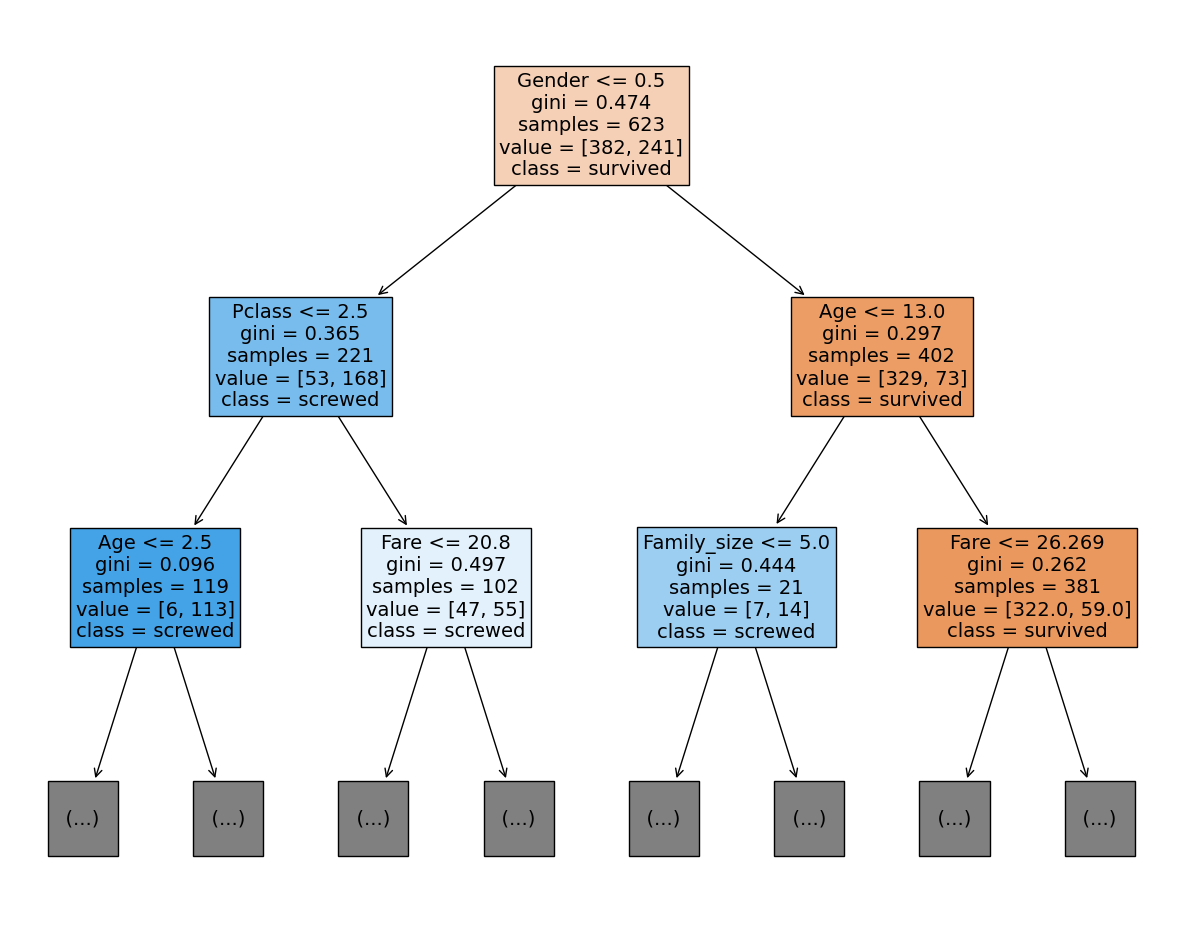

In [198]:
tree_fig = plt.figure(figsize = (15,12))

tree_fig = tree.plot_tree(
                            tree_clf
                            ,max_depth = 2
                            , fontsize = 14
                            ,feature_names = X_train.columns
                            ,filled = True
                            ,class_names = {0:'survived', 1: 'screwed'}
                         )
plt.show()

C:\Users\lothe\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


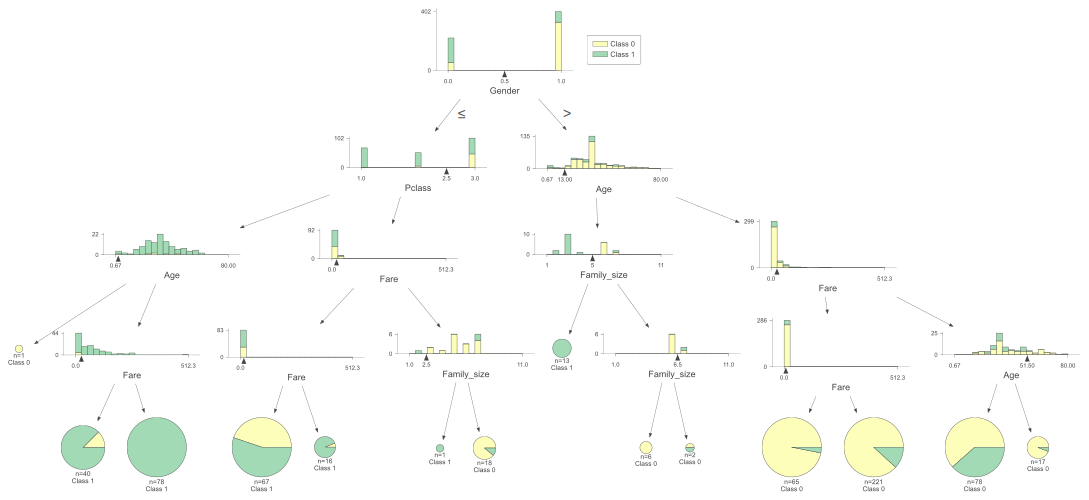

In [199]:
viz_model = dtreeviz.model(tree_clf, X_train, y_train,feature_names= X_train.columns)
viz_model.view()

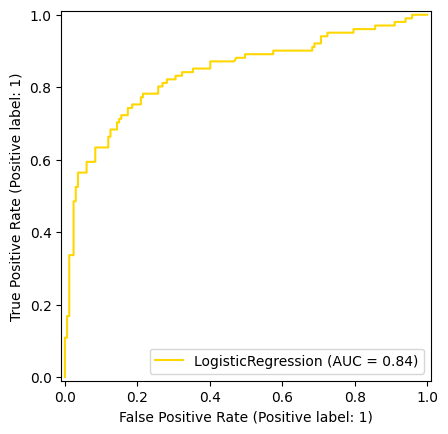

In [200]:
sk.metrics.RocCurveDisplay.from_estimator(log_clf, X_test, y_test, color ='gold')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

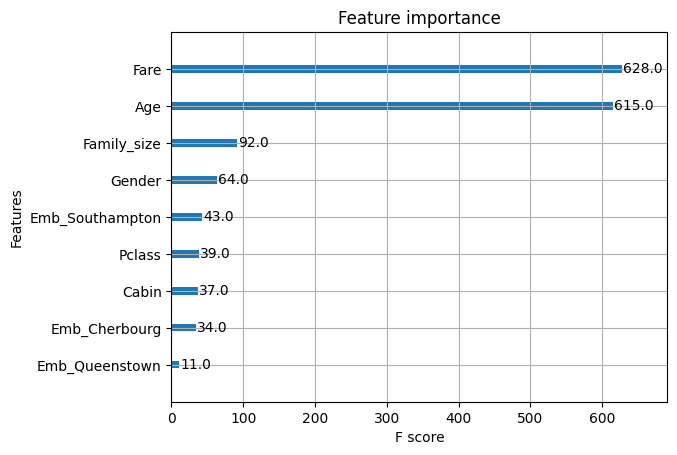

In [201]:
plot_importance(xgb_clf)

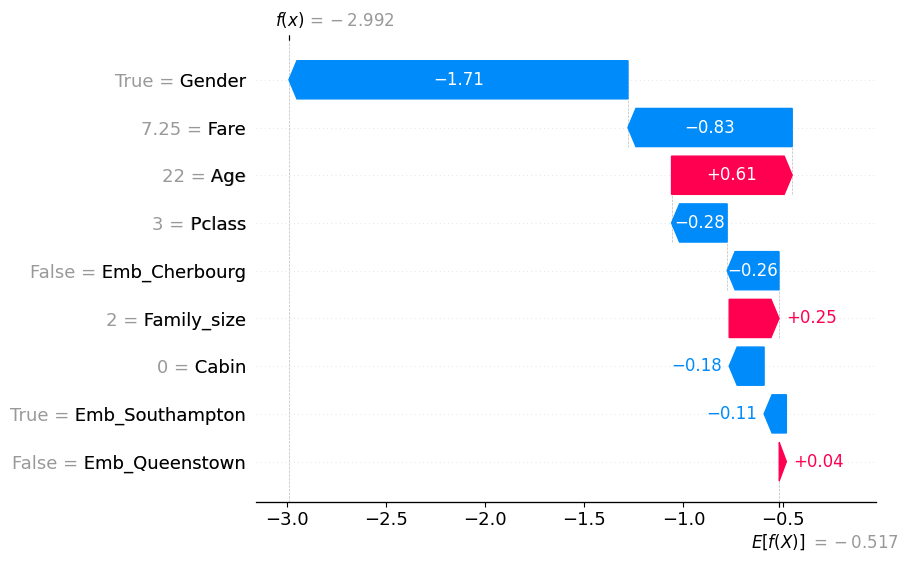

In [202]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(xgb_clf)
shap_values = explainer(X)
# print the JS visualization code to the notebook
shap.initjs()
# visualize the first prediction's explana
shap.plots.waterfall(shap_values[0])

In [203]:
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

In [204]:
# visualize all the training set predictions
shap.plots.force(shap_values[:500])

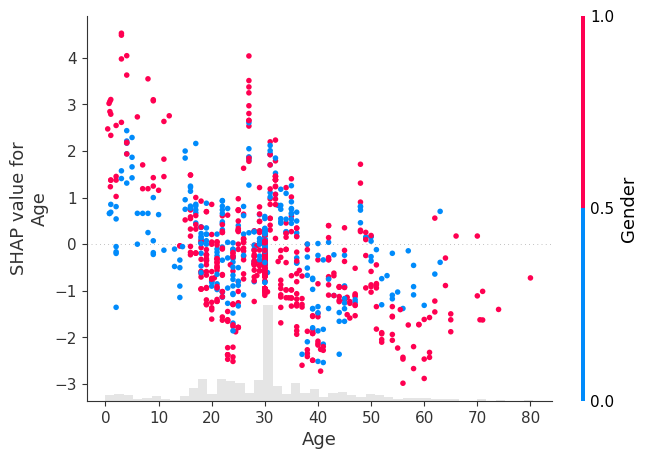

In [205]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, "Age"], color=shap_values)

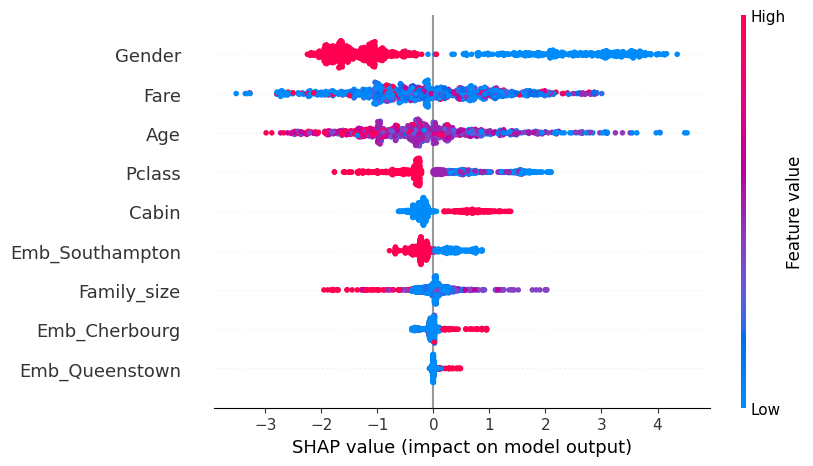

In [206]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

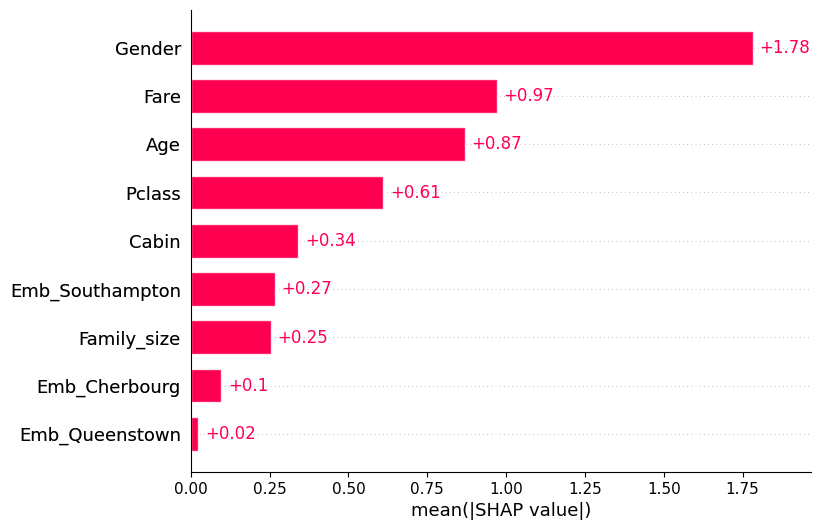

In [207]:
shap.plots.bar(shap_values)

<Axes: >

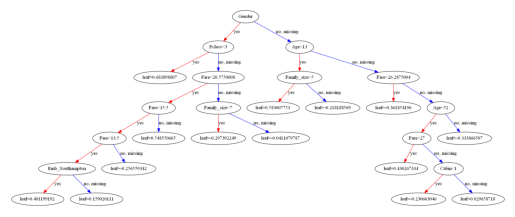

In [208]:
xgb.plot_tree(xgb_clf)

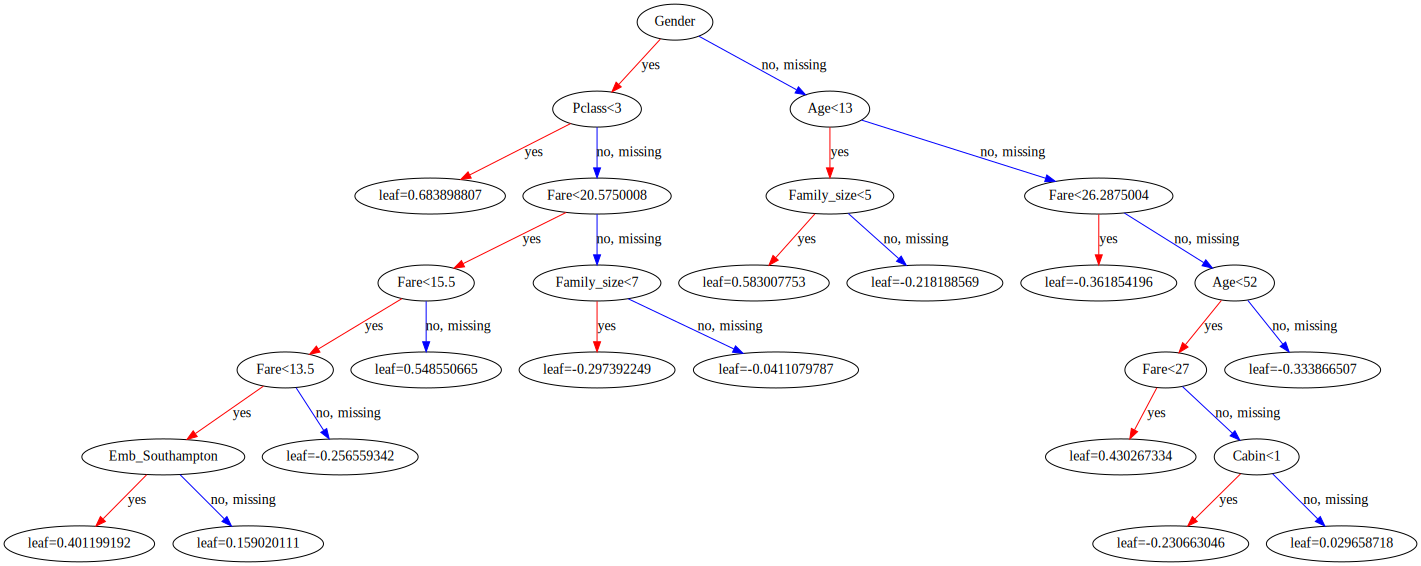

In [209]:
xgb.to_graphviz(xgb_clf)

## Show Predictions against test data set 

In [240]:
tree_preds = tree_clf.predict_proba(X_test)[:,1]
log_preds = log_clf.predict_proba(X_test)[:,1]
xgb_preds = xgb_clf.predict_proba(X_test)[:,1]

final = pd.DataFrame(X_test)
final['tree_preds'] = tree_preds
final['log_preds'] = log_preds
final['xgb_preds'] = xgb_preds
final['avg model score'] = (final['tree_preds'] + final['log_preds'] + final['xgb_preds']) / 3
final

,Pclass,Age,Fare,Cabin,Gender,Family_size,Emb_Southampton,Emb_Cherbourg,Emb_Queenstown,tree_preds,log_preds,xgb_preds,avg model score
432,2,42.00,26.00,0,False,2,True,False,False,0.88,0.65,0.60,0.71
10,3,4.00,16.70,1,False,3,True,False,False,0.94,0.88,0.99,0.94
38,3,18.00,18.00,0,False,3,True,False,False,0.94,0.64,0.98,0.85
747,2,30.00,13.00,0,False,1,True,False,False,0.88,0.75,0.95,0.86
314,2,43.00,26.25,0,True,3,True,False,False,0.12,0.11,0.05,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
865,2,42.00,13.00,0,False,1,True,False,False,0.88,0.68,0.70,0.75
136,1,19.00,26.28,1,False,3,True,False,False,1.00,0.95,0.99,0.98
131,3,20.00,7.05,0,True,1,True,False,False,0.03,0.13,0.00,0.06
556,1,48.00,39.60,1,False,2,False,True,False,1.00,0.90,1.00,0.97


# Save Test dataset ready for processing in the api


In [241]:
final.to_parquet('tit_test.parquet')

## Save Model(s) down for use in FastAPI

In [247]:
# will use both pickle and JSON just in case
with open(file = 'tree_model.pkl',mode = 'wb') as f:
    pickle.dump(tree_clf,f)

with open(file = 'log_model.pkl',mode = 'wb') as f:
    pickle.dump(log_clf,f)

with open(file = 'xgb_model.pkl',mode = 'wb') as f:
    pickle.dump(xgb_clf,f)